In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import many
import cancer_data

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statsmodels.stats.multitest import multipletests

# Load data

In [4]:
depmap_damaging = cancer_data.load("depmap_damaging")
depmap_hotspot = cancer_data.load("depmap_hotspot")
depmap_cn = cancer_data.load("depmap_copy_number")
ccle_genex = cancer_data.load("ccle_gene_tpm")
ccle_exonusage = cancer_data.load("ccle_exonusage")
avana = cancer_data.load("avana")

In [5]:
go_rna_splicing_genes = pd.read_csv("../data/raw/go_rna_splicing_genes.csv")
go_rna_splicing_genes_set = set(go_rna_splicing_genes["ensembl_gene_id"])

ensembl_paralogs = pd.read_feather(
    "../data/intermediate/paralog_mutation_splicing_correlations.feather"
)

damaging_pvals = ensembl_paralogs["damaging_pval"].dropna()
hotspot_pvals = ensembl_paralogs["hotspot_pval"].dropna()
spearman_pvals = ensembl_paralogs["cn_spearman_pval"].dropna()
pearson_pvals = ensembl_paralogs["cn_pearson_pval"].dropna()

ensembl_paralogs["damaging_qval"] = pd.Series(
    multipletests(
        damaging_pvals,
        alpha=0.01,
        method="fdr_bh",
    )[1],
    index=damaging_pvals.index,
)

ensembl_paralogs["hotspot_qval"] = pd.Series(
    multipletests(
        hotspot_pvals,
        alpha=0.01,
        method="fdr_bh",
    )[1],
    index=hotspot_pvals.index,
)

ensembl_paralogs["cn_spearman_qval"] = pd.Series(
    multipletests(
        spearman_pvals,
        alpha=0.01,
        method="fdr_bh",
    )[1],
    index=spearman_pvals.index,
)

ensembl_paralogs["cn_pearson_qval"] = pd.Series(
    multipletests(
        pearson_pvals,
        alpha=0.01,
        method="fdr_bh",
    )[1],
    index=pearson_pvals.index,
)

In [6]:
ensembl_paralogs["label"] = (
    ensembl_paralogs["external_gene_name"].fillna("")
    + " • "
    + ensembl_paralogs["ccle_paralog_exons"].apply(lambda x: "_".join(x.split("_")[:-1]))
)

ensembl_paralogs.index = ensembl_paralogs["ensembl_gene_id"] + "-" + ensembl_paralogs["ccle_paralog_exons"]
ensembl_paralogs["is_rna_splicing"] = ensembl_paralogs["ensembl_gene_id"].isin(go_rna_splicing_genes_set)

# Plot copynumber correlations

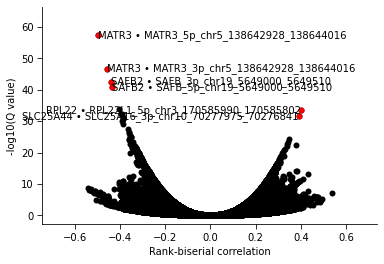

In [7]:
labels_mask = (
    (ensembl_paralogs["cn_spearman_qval"] < 1e-30)
    & (ensembl_paralogs["cn_spearman_r"] > 0)
) | (
    (ensembl_paralogs["cn_spearman_qval"] < 1e-40)
    & (ensembl_paralogs["cn_spearman_r"] < 0)
)

many.visuals.dense_plot(
    ensembl_paralogs["cn_spearman_r"],
    -np.log10(ensembl_paralogs["cn_spearman_qval"]),
    text_adjust=False,
    labels_mask=labels_mask,
    labels=ensembl_paralogs["label"],
    colormap=None,
)

plt.xlabel("Rank-biserial correlation")
plt.ylabel("-log10(Q value)")

plt.savefig(
    "../plots/cn_splicing_spearman_associations.pdf", dpi=512, bbox_inches="tight", transparent=True
)

In [8]:
def plot_cn_exonusage(row_id, ax=None, text_pos=(0.1, 0.9)):
    row = ensembl_paralogs.loc[row_id]

    depmap_gene = row["depmap_gene"]
    exon = row["ccle_paralog_exons"]

    #     sns.scatterplot(x=depmap_cn[depmap_gene], y=ccle_exonusage[exon])

    if ax is None:
        plt.figure(figsize=(4, 4))
        ax = plt.subplot(111)

    many.visuals.regression(
        x=depmap_cn[depmap_gene],
        y=ccle_exonusage[exon],
        method="spearman",
        alpha=0.25,
        scatter_kwargs={"c": "black", "s":16},
        ax=ax,
        text_pos=text_pos
    )

    ax.set_xlabel(f'{depmap_gene.split("_")[0]} copy number')
    ax.set_ylabel(f"{exon.split('_')[0]}\n{'_'.join(exon.split('_')[1:-1])}")
    
    return ax

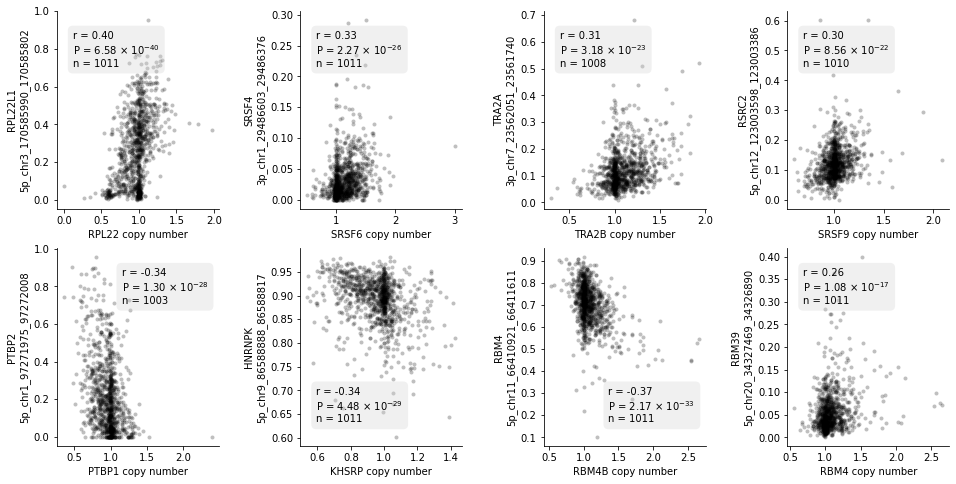

In [9]:
plt.figure(figsize=(16, 8))

ax = plt.subplot(241)
plot_cn_exonusage(
    "ENSG00000116251-RPL22L1_5p_chr3_170585990_170585802_ENSG00000163584.13", ax
)

ax = plt.subplot(242)
plot_cn_exonusage(
    "ENSG00000124193-SRSF4_3p_chr1_29486603_29486376_ENSG00000116350.11", ax
)

ax = plt.subplot(243)
plot_cn_exonusage(
    "ENSG00000136527-TRA2A_3p_chr7_23562051_23561740_ENSG00000164548.6", ax
)

ax = plt.subplot(244)
plot_cn_exonusage(
    "ENSG00000111786-RSRC2_5p_chr12_123003598_123003386_ENSG00000111011.13", ax
)

ax = plt.subplot(245)
plot_cn_exonusage(
    "ENSG00000011304-PTBP2_5p_chr1_97271975_97272008_ENSG00000117569.14",
    ax,
    text_pos=(0.4, 0.9),
)

ax = plt.subplot(246)
plot_cn_exonusage(
    "ENSG00000088247-HNRNPK_5p_chr9_86588888_86588817_ENSG00000165119.14",
    ax,
    text_pos=(0.1, 0.3),
)

ax = plt.subplot(247)
plot_cn_exonusage(
    "ENSG00000173914-RBM4_5p_chr11_66410921_66411611_ENSG00000173933.15",
    ax,
    text_pos=(0.4, 0.3),
)

ax = plt.subplot(248)
plot_cn_exonusage(
    "ENSG00000173933-RBM39_5p_chr20_34327469_34326890_ENSG00000131051.16", ax
)

plt.subplots_adjust(wspace=0.5)

plt.savefig("../plots/cn_splicing_examples.pdf", dpi=512, transparent=True)

# Plot mutation correlations

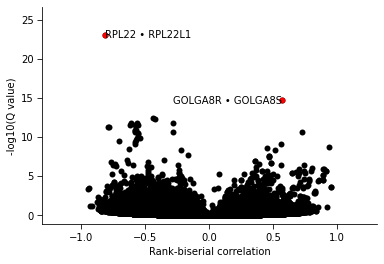

In [7]:
many.visuals.dense_plot(
    ensembl_paralogs["hotspot_biserial"],
    -np.log10(ensembl_paralogs["hotspot_qval"]),
    text_adjust=False,
    labels_mask=ensembl_paralogs["hotspot_qval"] < 1e-14,
    labels=ensembl_paralogs["label"],
    colormap=None,
)

plt.xlabel("Rank-biserial correlation")
plt.ylabel("-log10(Q value)")

plt.savefig(
    "../plots/hotspot_splicing_associations.pdf", dpi=512, bbox_inches="tight", transparent=True
)

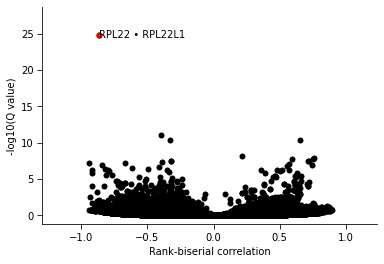

In [8]:
many.visuals.dense_plot(
    ensembl_paralogs["damaging_biserial"],
    -np.log10(ensembl_paralogs["damaging_qval"]),
    text_adjust=False,
    labels_mask=ensembl_paralogs["damaging_qval"] < 1e-15,
    labels=ensembl_paralogs["label"],
    colormap=None,
)

plt.xlabel("Rank-biserial correlation")
plt.ylabel("-log10(Q value)")

plt.savefig(
    "../plots/damaging_splicing_associations.pdf", dpi=512, bbox_inches="tight", transparent=True
)